<div align="center">

### **PARCIAL #2 SEÑALES Y SISTEMAS - 2025 2S**
#### **Estudiante:** Martín Ramírez Espinosa
##### Departamento de Ingeniería Eléctrica, Electrónica y Computación
##### Universidad Nacional de Colombia - Sede Manizales

</div>

---

In [38]:
import numpy as np
import shutil
from pathlib import Path
from typing import Tuple, Optional
from yt_dlp import YoutubeDL
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

---

**1.** Considere el demodulador AM mostrado en la siguiente figura:

<p align="center"><img src="demodulation-system.png" alt="Diagrama de demodulación AM" style="max-width:100%; width:85%;"></p>

Suponiendo $\theta_0 = 0$, deduzca analíticamente el espectro de Fourier teórico en cada etapa del esquema. Posteriormente, tome 5 segundos de una canción de YouTube como señal de mensaje $m(t)$ y represente en el dominio del tiempo y de la frecuencia las etapas principales del proceso de modulación y demodulación, reproduciendo el audio asociado en cada caso. Para la etapa pasa-bajas implemente un filtrado ideal en el dominio de la frecuencia mediante FFT.

In [25]:
def clear_cache(cache_dir: Optional[str] = None) -> None:
    cache_path = Path(cache_dir) if cache_dir else Path.cwd() / "cache"
    if not cache_path.exists() or not cache_path.is_dir():
        return

    for entry in cache_path.iterdir():
        if entry.name == ".gitignore":
            continue
        if entry.is_dir():
            shutil.rmtree(entry)
        else:
            entry.unlink()

def get_audio(
    url: str,
    start_s: float = 0.0,
    duration_s: float = 5.0,
    sample_rate_hz: int = 44100,
    cache_dir: Optional[str] = None,
    clean_cache: bool = True,
) -> Tuple[np.ndarray, int]:

    cache_path = Path(cache_dir) if cache_dir else Path.cwd() / "cache"
    if clean_cache:
        clear_cache(cache_path)
    cache_path.mkdir(parents=True, exist_ok=True)

    ydl_opts = {
        "format": "bestaudio/best",
        "outtmpl": str(cache_path / "%(id)s.%(ext)s"),
        "quiet": True,
        "no_warnings": True,
    }

    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)
        audio_file = cache_path / f"{info['id']}.{info['ext']}"

    segment = AudioSegment.from_file(audio_file)
    start_ms = max(int(start_s * 1000), 0)
    end_ms = start_ms + int(duration_s * 1000)
    segment = segment[start_ms:end_ms].set_channels(1).set_frame_rate(sample_rate_hz)

    raw = np.asarray(segment.get_array_of_samples())
    samples = raw.astype(np.float32) / np.iinfo(raw.dtype).max
    return samples, sample_rate_hz

In [31]:
link = "https://www.youtube.com/watch?v=DraDpi4bM-Y"

In [41]:
msg_t, f_s = get_audio(link, start_s = 15.0)

In [42]:
def plot_domains(msg_t, f_s):
    N = len(msg_t)
    T_s = 1.0 / f_s
    t = np.linspace(0.0, N*T_s, N, endpoint=False)

    msg_f = fft(msg_t)
    f = fftfreq(N, T_s)[:N//2]

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t, msg_t)
    plt.title("Time Domain")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")

    plt.subplot(2, 1, 2)
    plt.plot(f, 2.0/N * np.abs(msg_f[0:N//2]))
    plt.title("Frequency Domain")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")

    plt.tight_layout()
    plt.show()

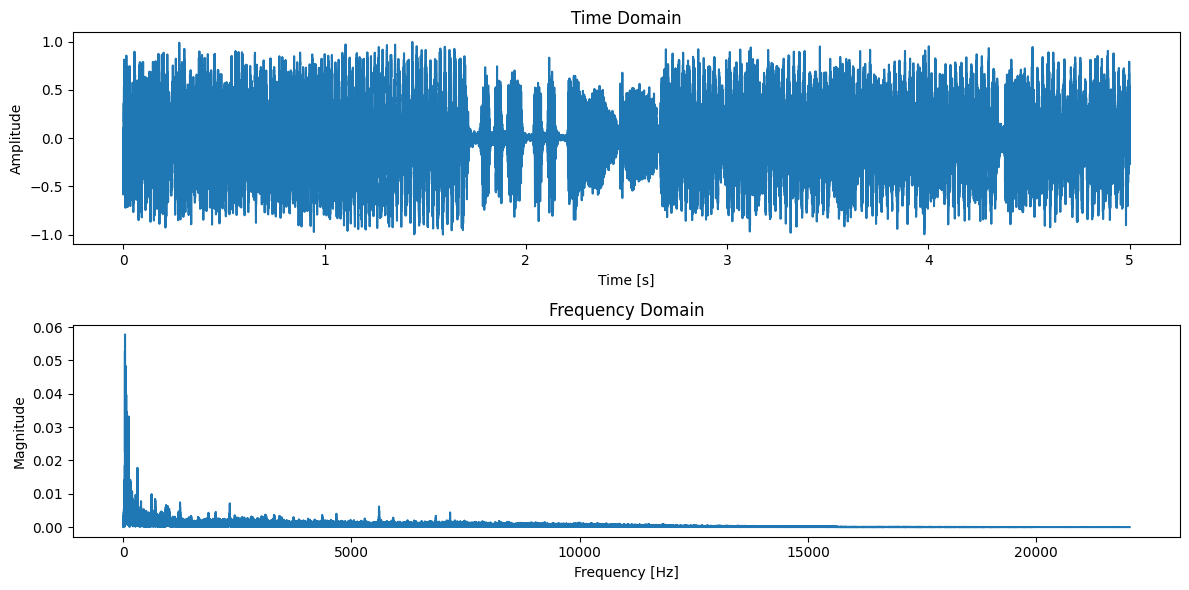

In [43]:
plot_domains(msg_t, f_s)

---

---

**2.** Determine la función de transferencia que modela el sistema masa-resorte-amortiguador presentado en la siguiente figura:

<p align="center"><img src="spring-mass-damper.png" alt="Sistema masa resorte amortiguador" style="max-width:70%; width:38%;"></p>

Obtenga a continuación el modelo equivalente a partir del circuito eléctrico mostrado:

<p align="center"><img src="rlc-system.png" alt="Circuito RLC equivalente" style="max-width:80%; width:55%;"></p>

Proponga valores numéricos para $m, k$ y $c$ y para sus equivalentes $R, L$ y $C$ que permitan simular regímenes subamortiguado, sobreamortiguado y de amortiguamiento crítico; calcule en cada caso el factor de amortiguamiento, la frecuencia natural amortiguada, la frecuencia natural no amortiguada, el tiempo pico, el tiempo de levantamiento y el tiempo de establecimiento. Para cada escenario, grafique el diagrama de polos y ceros, el diagrama de Bode, la respuesta impulso, la respuesta al escalón y la respuesta a la rampa. Repita el procedimiento para el sistema en lazo cerrado.